In [1]:
import os
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from lenstools import ConvergenceMap
from astropy import units as u
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from src.utils import load_config, setup_logging

In [3]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
config = load_config(config_file)
setup_logging()
zs =2.0

In [4]:
patch_size = config["patch_size"]
nbin = config["nbin"]

lmin, lmax = config["lmin"], config["lmax"]
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1, endpoint=True)
ell = (l_edges[1:] + l_edges[:-1]) / 2

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
nu = (bins[1:] + bins[:-1]) / 2

In [5]:
sample_patch_tiled_path = list((workdir / "data" / "patches"/ "tiled"/ f"zs{zs}").glob(f"*.npy"))[1]
sample_patch_bigbox_path = list((workdir / "data" / "patches"/ "bigbox"/ f"zs{zs}").glob(f"*.npy"))[1]

In [6]:
sample_patch_tiled = np.load(sample_patch_tiled_path)
sample_patch_bigbox = np.load(sample_patch_bigbox_path)

In [7]:
smoothed_map_tiled = ConvergenceMap(sample_patch_tiled[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)
smoothed_map_bigbox = ConvergenceMap(sample_patch_bigbox[0], angle=patch_size * u.deg).smooth(2.0 * u.arcmin)

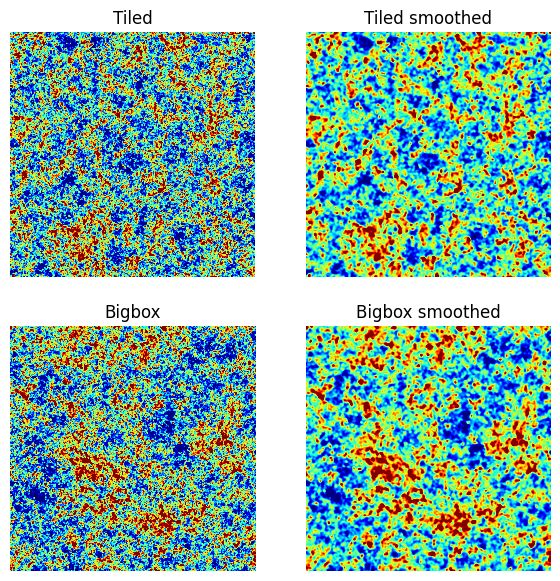

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))

ax[0, 0].imshow(sample_patch_tiled[0], cmap="jet", vmin=-0.032, vmax=0.032)
ax[0, 0].set_title("Tiled")

ax[0, 1].imshow(smoothed_map_tiled.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[0, 1].set_title("Tiled smoothed")

ax[1, 0].imshow(sample_patch_bigbox[0], cmap="jet", vmin=-0.032, vmax=0.032)
ax[1, 0].set_title("Bigbox")

ax[1, 1].imshow(smoothed_map_bigbox.data, cmap="jet", vmin=-0.032, vmax=0.032)
ax[1, 1].set_title("Bigbox smoothed")

for a in ax.ravel():
    a.axis("off")

plt.show()

In [9]:
statfile_tiled = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/tiled/patch_stats_tiled_oa10_noiseless_sl2.npy"
statfile_bigbox = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev/bigbox/patch_stats_bigbox_oa10_noiseless_sl2.npy"

stats_tiled = np.load(statfile_tiled, allow_pickle=True).item()
stats_bigbox = np.load(statfile_bigbox, allow_pickle=True).item()

# cl

In [10]:
def discretize_cl(cl_cont,lmin=300, lmax=3000, nbin=15):
        l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1)
        ell = np.arange(2, lmax + 1)
        bin_indices = np.digitize(ell, l_edges, right=True)

        # Exclude out-of-range indices
        valid = (bin_indices > 0) & (bin_indices <= nbin)
        bin_indices = bin_indices[valid]
        cl_values = cl_cont # Assuming cl_cont starts at ell=0

        cl_sum = np.bincount(bin_indices, weights=cl_values[valid], minlength=nbin + 1)
        counts = np.bincount(bin_indices, minlength=nbin + 1)

        with np.errstate(divide='ignore', invalid='ignore'):
            cl_disc = np.divide(cl_sum, counts, where=counts > 0)[1:nbin + 1]

        return cl_disc

In [11]:
# Fullsky area in square degrees 
fs_area = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 100 / fs_area
l_area = 2 * np.pi * ell * np.diff(l_edges) + np.pi * np.diff(l_edges) ** 2
nmodes = f_sky * l_area 

# load theoretical data
file_paths = (workdir / "theory" /  "halofit").glob("*.npz")
file_paths = sorted(file_paths)
cl_theory = {}
for zs in [0.5, 1.0, 1.5, 2.0, 2.5]:
    for file_path in file_paths:
        if f"zs{zs}" in file_path.name:
            data = np.load(file_path)
            clkk = discretize_cl(data["clkk"], lmin=lmin, lmax=lmax, nbin=nbin) * ell * (ell + 1) / (2 * np.pi)
            clkk_cov= clkk**2 / nmodes * 2
            cl_theory[zs] = {"clkk":clkk, "clkk_cov":clkk_cov, "ell":data["ell"]}

In [12]:
n=3

clkk_bigbox = {}
clkk_tiled = {}

for zs in [0.5, 1.0, 1.5, 2.0, 2.5]:
    clkk_bigbox[zs] = {"means": stats_bigbox[zs]["means"][15*n:15*(n+1)], "stds": stats_bigbox[zs]["stds"][15*n:15*(n+1)], "cov": stats_bigbox[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_bigbox[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_bigbox[zs]["diags"][15*n:15*(n+1)]}
    clkk_tiled[zs] = {"means": stats_tiled[zs]["means"][15*n:15*(n+1)], "stds": stats_tiled[zs]["stds"][15*n:15*(n+1)], "cov": stats_tiled[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_tiled[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_tiled[zs]["diags"][15*n:15*(n+1)]}

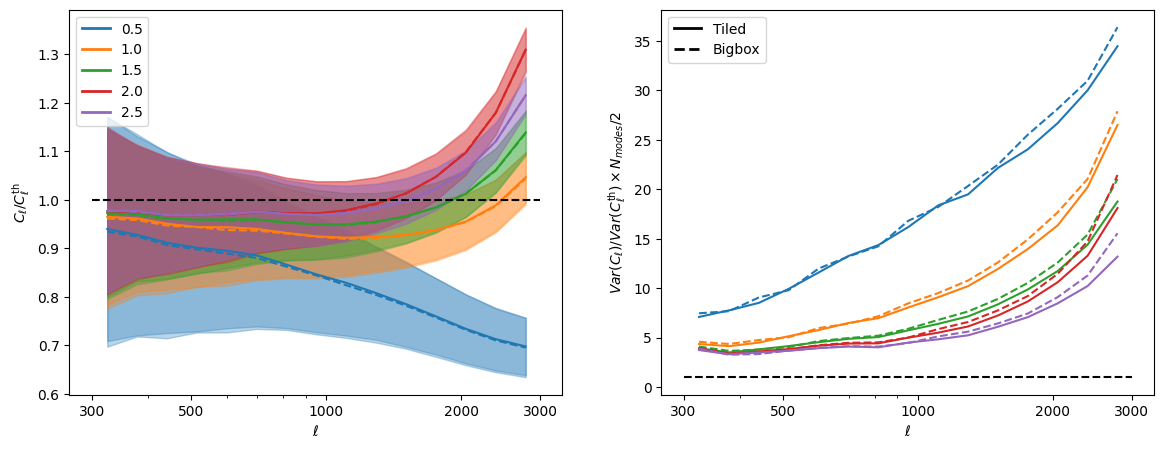

In [13]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    # plot the ratio to the theory
    ax[0].plot(ell, clkk_tiled[zs]["means"]/cl_theory[zs]["clkk"], color=colors[i])
    ax[0].fill_between(ell, (clkk_tiled[zs]["means"] - clkk_tiled[zs]["stds"])/cl_theory[zs]["clkk"], (clkk_tiled[zs]["means"] + clkk_tiled[zs]["stds"])/cl_theory[zs]["clkk"], alpha=0.3, color=colors[i])
    
    ax[0].plot(ell, clkk_bigbox[zs]["means"]/cl_theory[zs]["clkk"], linestyle="--", color=colors[i])
    ax[0].fill_between(ell, (clkk_bigbox[zs]["means"] - clkk_bigbox[zs]["stds"])/cl_theory[zs]["clkk"], (clkk_bigbox[zs]["means"] + clkk_bigbox[zs]["stds"])/cl_theory[zs]["clkk"], alpha=0.3, color=colors[i])

    ax[1].plot(ell, clkk_tiled[zs]["diags"]/cl_theory[zs]["clkk_cov"], label=f"zs={zs}", color=colors[i])
    ax[1].plot(ell, clkk_bigbox[zs]["diags"]/cl_theory[zs]["clkk_cov"], label=f"zs={zs}", linestyle="--", color=colors[i])

ax[0].hlines(1, lmin, lmax, color="black", linestyle="--")
ax[0].set_xscale("log")
ax[0].set_xlabel(r"$\ell$")
ax[0].set_ylabel(r"$C_{\ell} / C_{\ell}^{\mathrm{th}}$")
# show tick [300, 500, 1000, 2000, 3000]
ax[0].set_xticks([300, 500, 1000, 2000, 3000])
ax[0].set_xticklabels(["300", "500", "1000", "2000", "3000"])

ax[1].hlines(1, lmin, lmax, color="black", linestyle="--")
ax[1].set_xscale("log")
ax[1].set_xlabel(r"$\ell$")
ax[1].set_ylabel(r"$Var(C_{\ell}) / Var(C_{\ell}^{\mathrm{th}}) \times N_{modes} / 2$")
# show tick [300, 500, 1000, 2000, 3000]
ax[1].set_xticks([300, 500, 1000, 2000, 3000])
ax[1].set_xticklabels(["300", "500", "1000", "2000", "3000"])


# show the legend about the color
custom_lines = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(zs_list))]
ax[0].legend(custom_lines, zs_list, loc="upper left")

# show the legend about the linestyle
custom_lines = [Line2D([0], [0], linestyle=ls, lw=2, color="black") for ls in ["-", "--"]]
ax[1].legend(custom_lines, ["Tiled", "Bigbox"], loc="upper left")

plt.show()

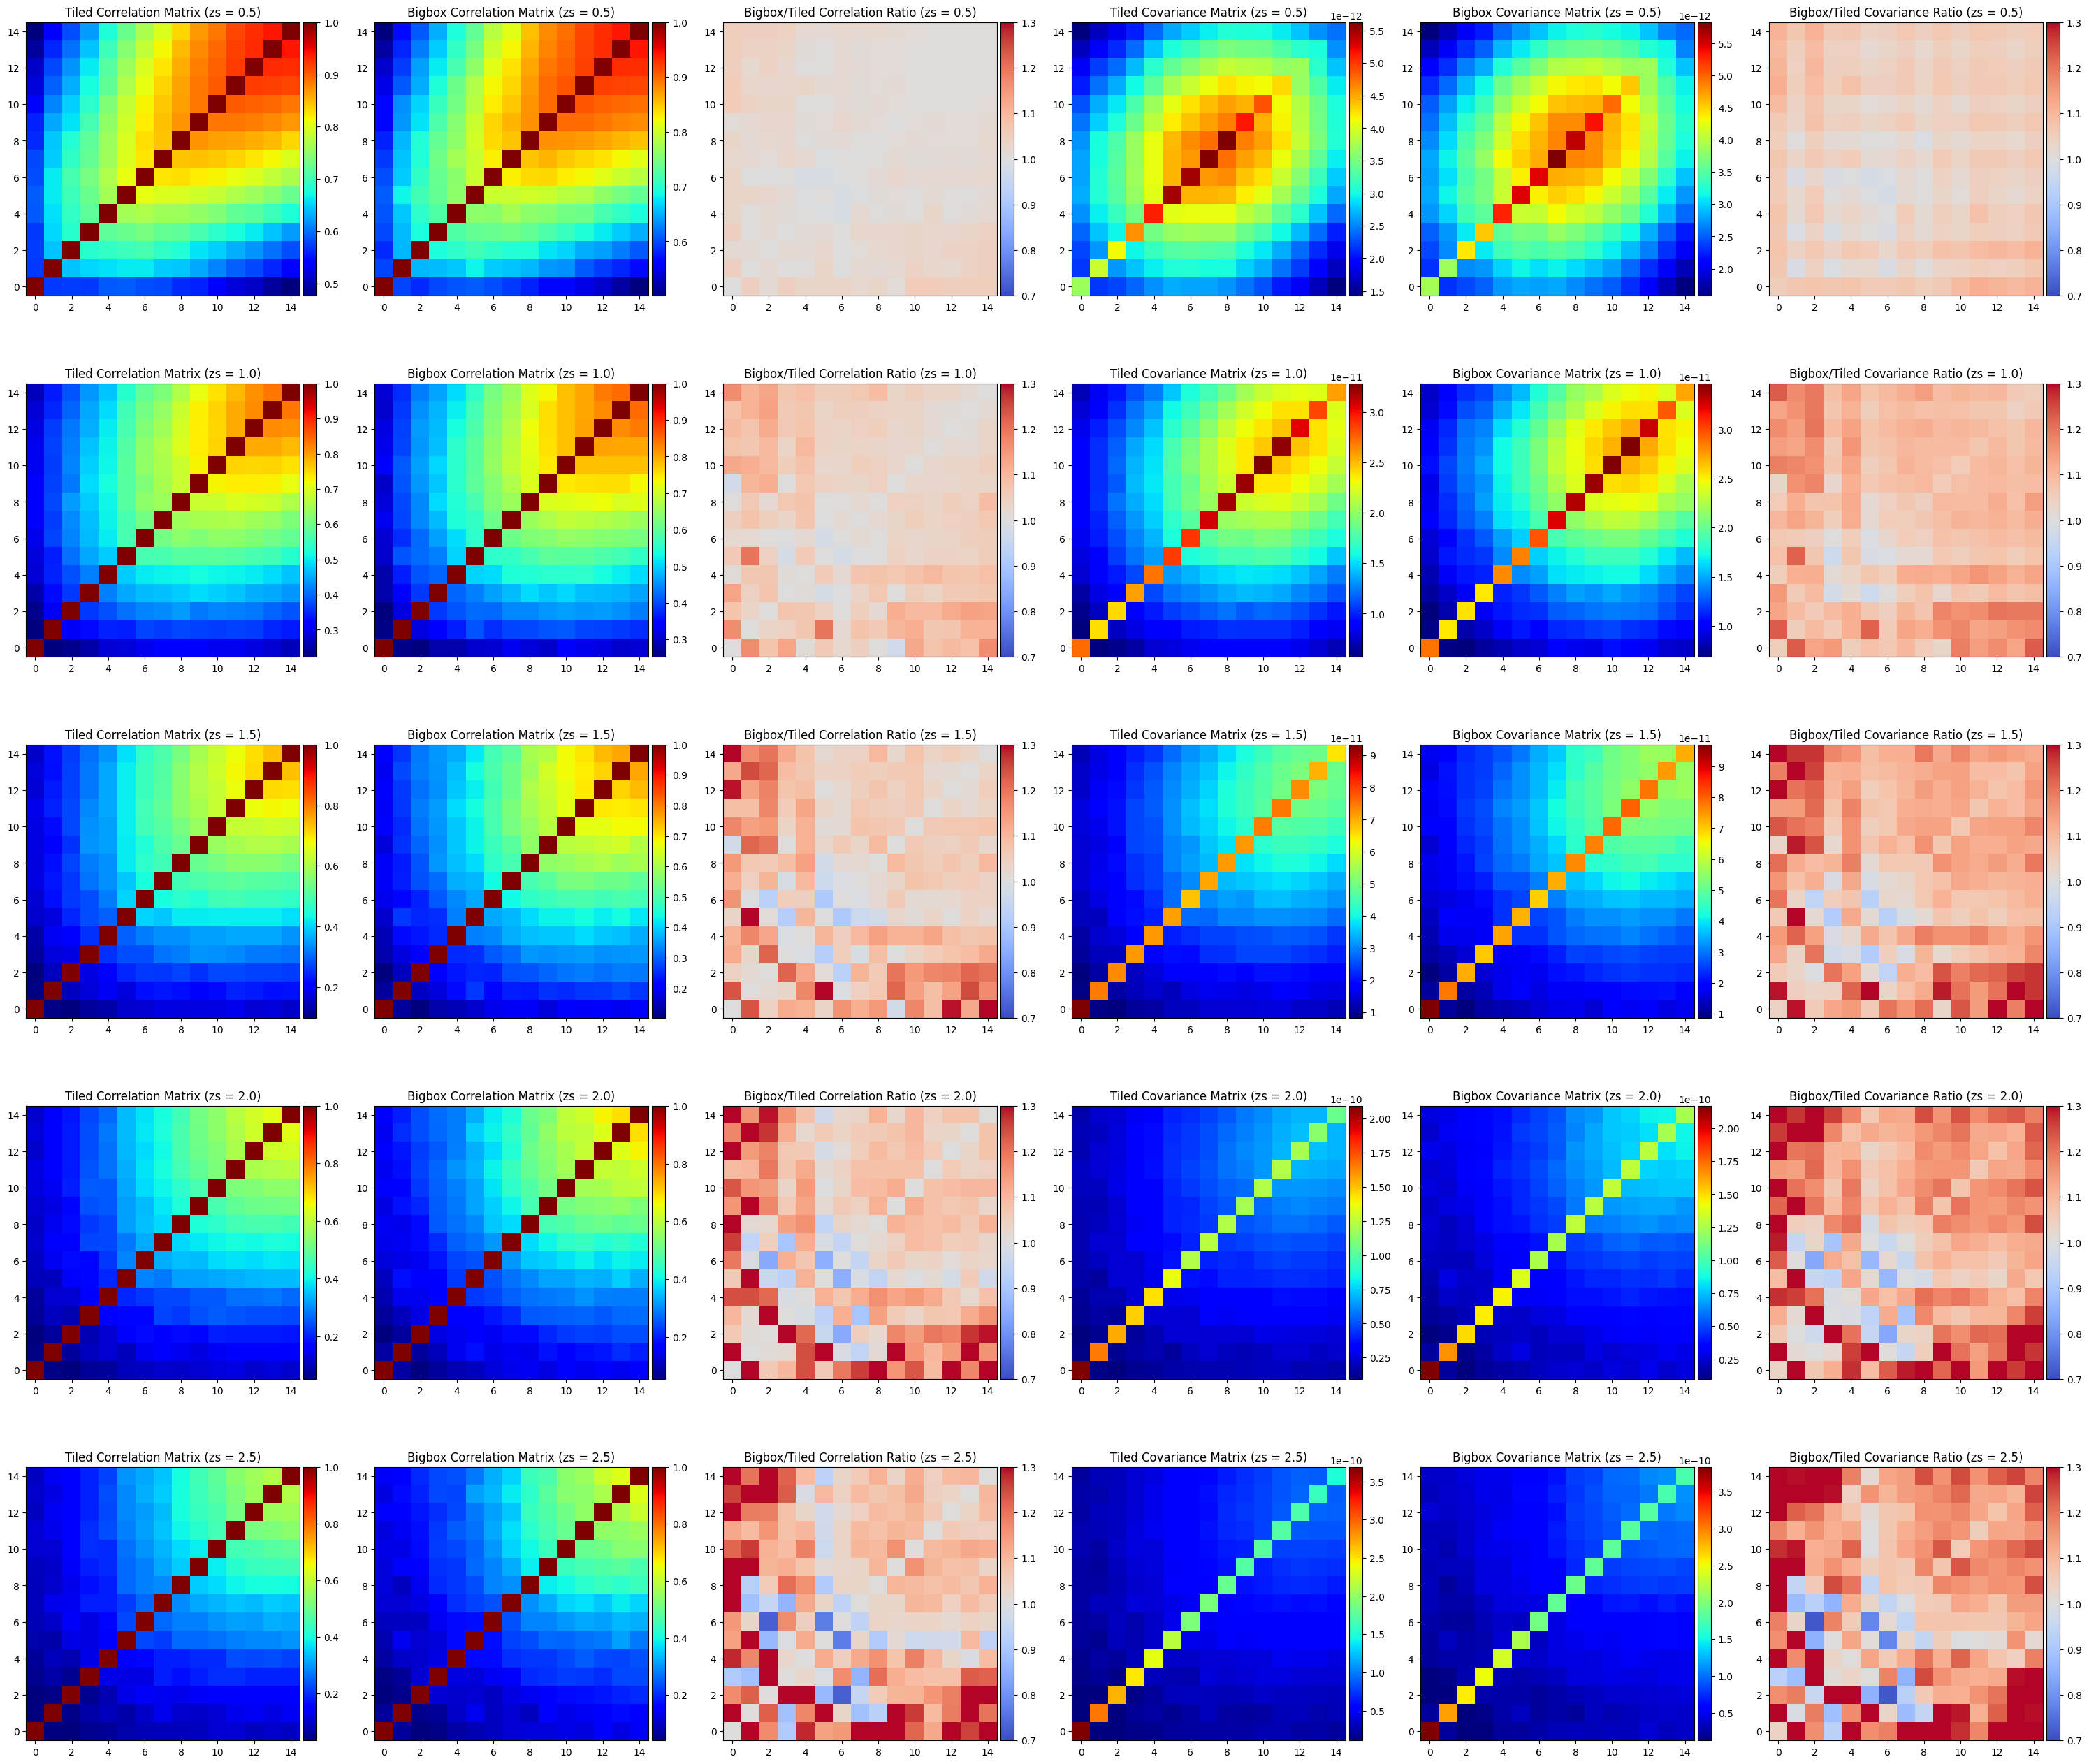

In [14]:
# plot correlation matrix and covariance matrix
fig, ax = plt.subplots(5, 6, figsize=(30, 26))
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    im = ax[i, 0].imshow(clkk_tiled[zs]["corr"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 0].set_title(f"Tiled Correlation Matrix (zs = {zs})")

    im = ax[i, 1].imshow(clkk_bigbox[zs]["corr"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 1].set_title(f"Bigbox Correlation Matrix (zs = {zs})")

    im = ax[i, 2].imshow(clkk_bigbox[zs]["corr"]/clkk_tiled[zs]["corr"], cmap="coolwarm", vmin=0.7, vmax=1.3, origin="lower")
    divider = make_axes_locatable(ax[i, 2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 2].set_title(f"Bigbox/Tiled Correlation Ratio (zs = {zs})")

    im = ax[i, 3].imshow(clkk_tiled[zs]["cov"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 3].set_title(f"Tiled Covariance Matrix (zs = {zs})")

    im = ax[i, 4].imshow(clkk_bigbox[zs]["cov"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 4])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 4].set_title(f"Bigbox Covariance Matrix (zs = {zs})")

    im = ax[i, 5].imshow(clkk_bigbox[zs]["cov"]/clkk_tiled[zs]["cov"], cmap="coolwarm", vmin=0.7, vmax=1.3, origin="lower")
    divider = make_axes_locatable(ax[i, 5])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 5].set_title(f"Bigbox/Tiled Covariance Ratio (zs = {zs})")

plt.tight_layout()
plt.show()

# bispectra

In [21]:
clkk_bigbox = {}
clkk_tiled = {}

for zs in [0.5, 1.0, 1.5, 2.0, 2.5]:
    clkk_bigbox[zs] = {}
    clkk_tiled[zs] = {}
    for n in range(3):
        clkk_bigbox[zs][n] = {"means": stats_bigbox[zs]["means"][15*n:15*(n+1)], "stds": stats_bigbox[zs]["stds"][15*n:15*(n+1)], "cov": stats_bigbox[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_bigbox[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_bigbox[zs]["diags"][15*n:15*(n+1)]}
        clkk_tiled[zs][n] = {"means": stats_tiled[zs]["means"][15*n:15*(n+1)], "stds": stats_tiled[zs]["stds"][15*n:15*(n+1)], "cov": stats_tiled[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_tiled[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_tiled[zs]["diags"][15*n:15*(n+1)]}

2024-12-01 07:45:00,915 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:45:00,939 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:45:00,962 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:45:00,987 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:45:01,011 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


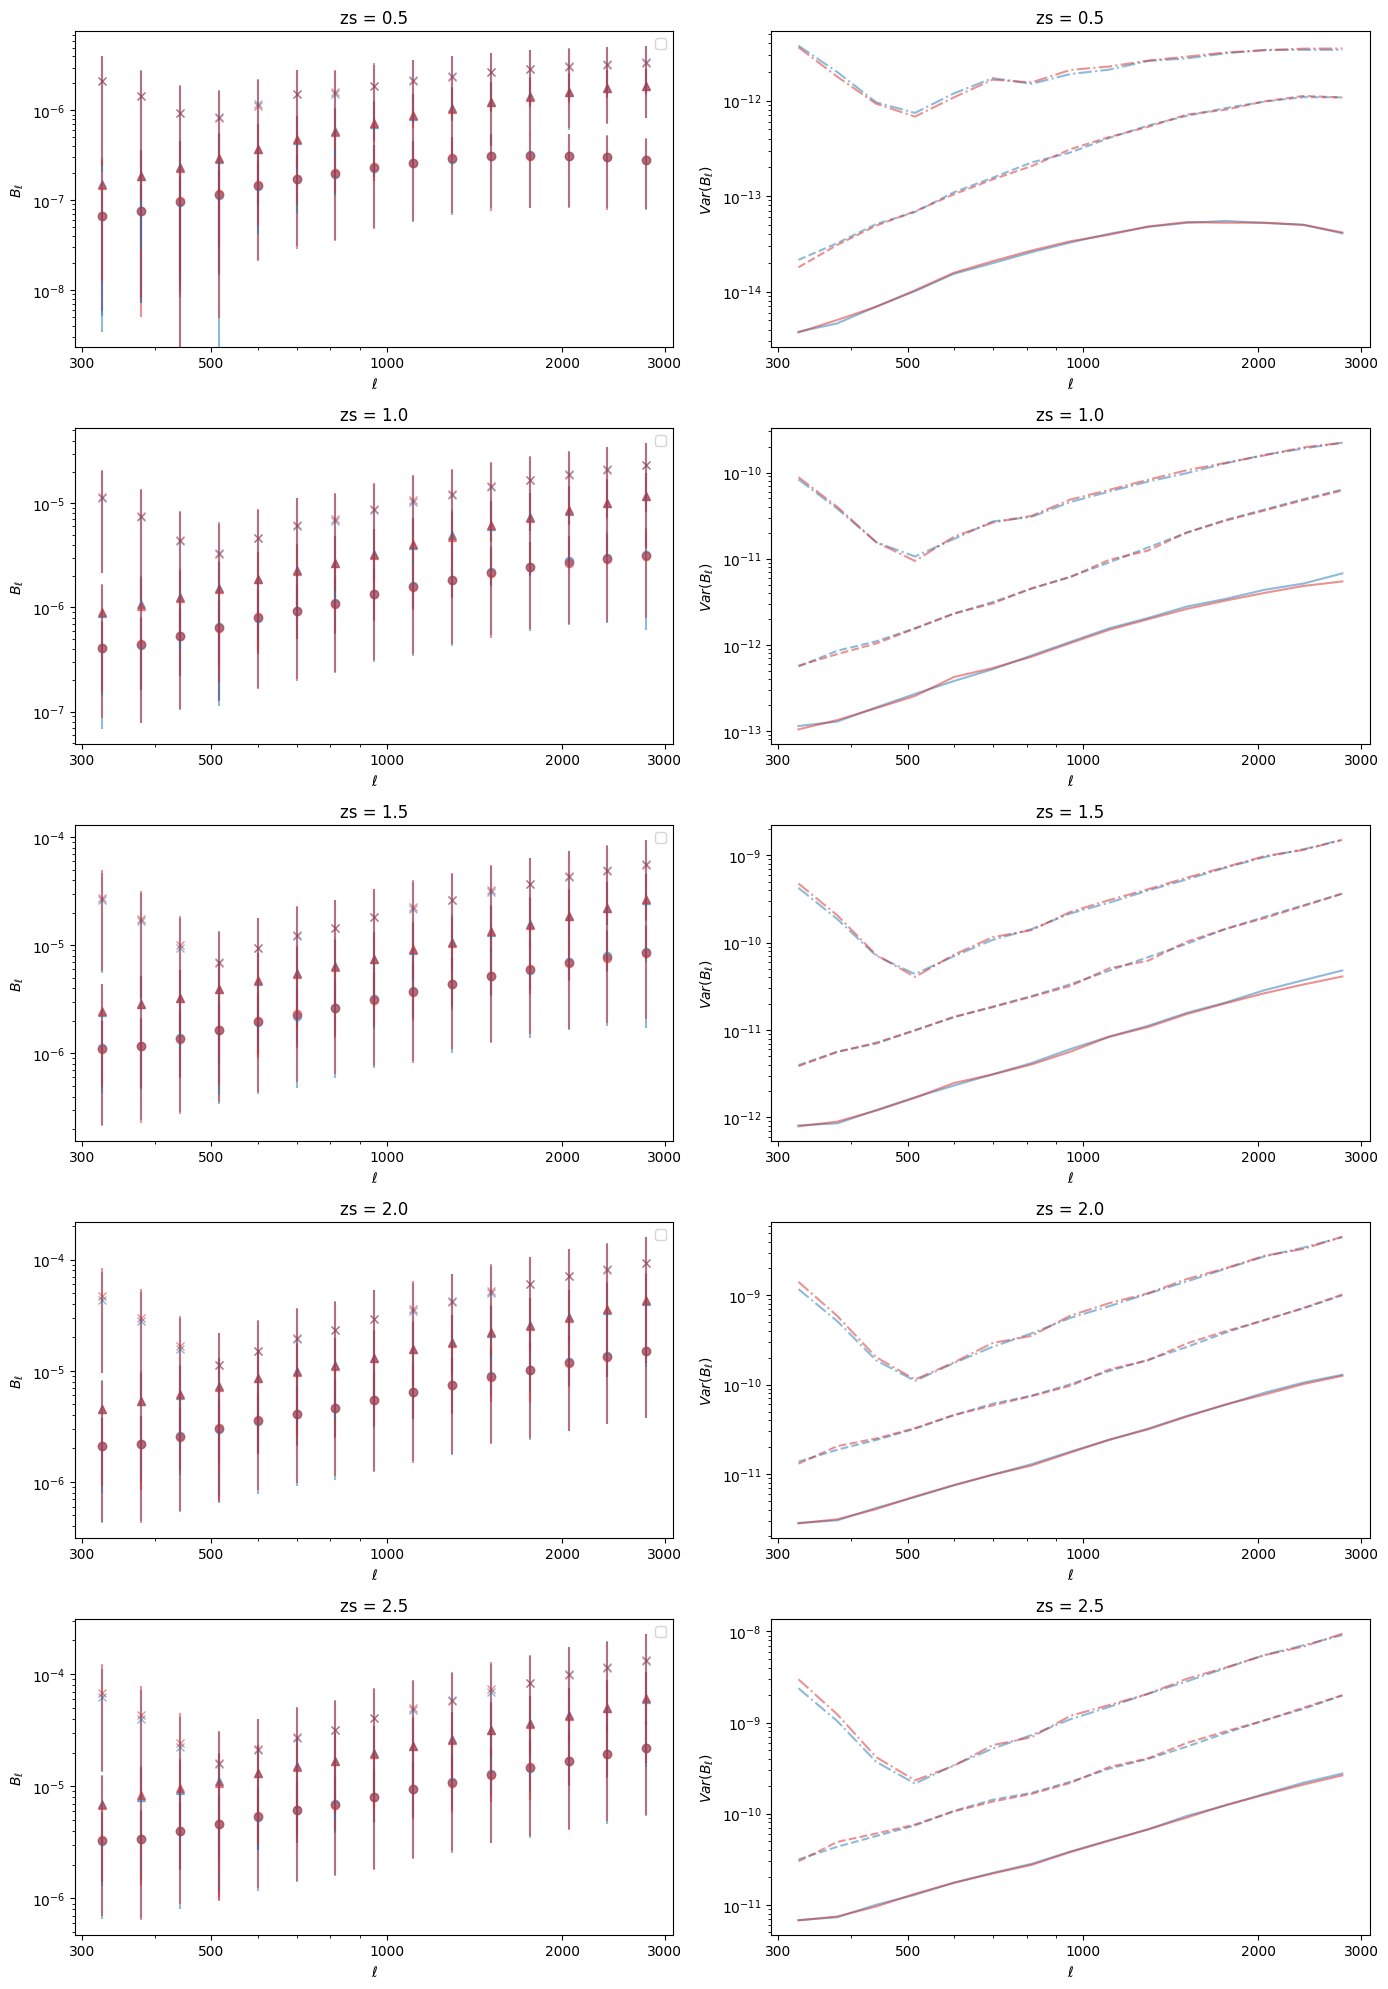

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(14, 20))
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    ax[i, 0].errorbar(ell, clkk_tiled[zs][0]["means"], yerr=clkk_tiled[zs][0]["stds"], fmt="o", color="tab:blue", alpha=0.5)
    ax[i, 0].errorbar(ell, clkk_bigbox[zs][0]["means"], yerr=clkk_bigbox[zs][0]["stds"], fmt="o", color="tab:red", alpha=0.5)

    ax[i, 0].errorbar(ell, clkk_tiled[zs][1]["means"], yerr=clkk_tiled[zs][1]["stds"], fmt="^", color="tab:blue", alpha=0.5)
    ax[i, 0].errorbar(ell, clkk_bigbox[zs][1]["means"], yerr=clkk_bigbox[zs][1]["stds"], fmt="^", color="tab:red", alpha=0.5)

    ax[i, 0].errorbar(ell, clkk_tiled[zs][2]["means"], yerr=clkk_tiled[zs][2]["stds"], fmt="x", color="tab:blue", alpha=0.5)
    ax[i, 0].errorbar(ell, clkk_bigbox[zs][2]["means"], yerr=clkk_bigbox[zs][2]["stds"], fmt="x", color="tab:red", alpha=0.5)
    
    ax[i, 0].set_xscale("log")
    ax[i, 0].set_yscale("log")
    ax[i, 0].set_xticks([300, 500, 1000, 2000, 3000])
    ax[i, 0].set_xticklabels(["300", "500", "1000", "2000", "3000"])

    ax[i, 0].set_title(f"zs = {zs}")
    ax[i, 0].set_xlabel(r"$\ell$")
    ax[i, 0].set_ylabel(r"$B_\ell$")
    ax[i, 0].legend()

    ax[i, 1].plot(ell, clkk_tiled[zs][0]["diags"], color="tab:blue", alpha = 0.5)
    ax[i, 1].plot(ell, clkk_bigbox[zs][0]["diags"], color="tab:red", alpha = 0.5)

    ax[i, 1].plot(ell, clkk_tiled[zs][1]["diags"], color="tab:blue", alpha = 0.5, linestyle="--")
    ax[i, 1].plot(ell, clkk_bigbox[zs][1]["diags"], color="tab:red", alpha = 0.5, linestyle="--")

    ax[i, 1].plot(ell, clkk_tiled[zs][2]["diags"], color="tab:blue", alpha = 0.5, linestyle="-.")
    ax[i, 1].plot(ell, clkk_bigbox[zs][2]["diags"], color="tab:red", alpha = 0.5, linestyle="-.")

    ax[i, 1].set_xscale("log")
    ax[i, 1].set_yscale("log")
    ax[i, 1].set_xticks([300, 500, 1000, 2000, 3000])
    ax[i, 1].set_xticklabels(["300", "500", "1000", "2000", "3000"])
    
    ax[i, 1].set_title(f"zs = {zs}")
    ax[i, 1].set_xlabel(r"$\ell$")
    ax[i, 1].set_ylabel(r"$Var(B_\ell)$")

plt.tight_layout()
plt.show()

# MFs

In [17]:
from scipy.special import erf

def Gaussian_MF(nu, sig1, sig0=1, mu=0):
    V0th = 0.5*(1.-erf((nu - mu )/(np.sqrt(2)*sig0)))
    V1th= (1./(sig0*8.*np.sqrt(2)))*sig1*np.exp(-1.*(nu-mu)**2/(2.*sig0**2)) 
    V2th=(1./(2.*(2*np.pi)**1.5))*np.exp(-(nu-mu)**2/(2.*sig0**2))*(nu-mu)*(sig1**2./sig0**3.)
    
    return V0th, V1th, V2th

def Gaussian_MF2(order, nu, sig1=1, sig0=1, mu=0):
    V0th = 0.5*(1.-erf((nu - mu )/(np.sqrt(2)*sig0)))
    V1th= (1./(sig0*8.*np.sqrt(2)))*sig1*np.exp(-1.*(nu-mu)**2/(2.*sig0**2)) 
    V2th=(1./(2.*(2*np.pi)**1.5))*np.exp(-(nu-mu)**2/(2.*sig0**2))*(nu-mu)*(sig1**2./sig0**3.)
    
    if order == 0:
        return V0th
    elif order == 1:
        return V1th
    elif order == 2:
        return V2th
    else:
        raise ValueError("order must be 0, 1, or 2")


In [18]:
clkk_bigbox = {}
clkk_tiled = {}

for zs in [0.5, 1.0, 1.5, 2.0, 2.5]:
    clkk_bigbox[zs] = {}
    clkk_tiled[zs] = {}
    for n in range(7, 10):
        clkk_bigbox[zs][n-7] = {"means": stats_bigbox[zs]["means"][15*n:15*(n+1)], "stds": stats_bigbox[zs]["stds"][15*n:15*(n+1)], "cov": stats_bigbox[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_bigbox[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_bigbox[zs]["diags"][15*n:15*(n+1)]}
        clkk_tiled[zs][n-7] = {"means": stats_tiled[zs]["means"][15*n:15*(n+1)], "stds": stats_tiled[zs]["stds"][15*n:15*(n+1)], "cov": stats_tiled[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_tiled[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_tiled[zs]["diags"][15*n:15*(n+1)]}

2024-12-01 07:43:12,229 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:43:12,247 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:43:12,264 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:43:12,280 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-12-01 07:43:12,296 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


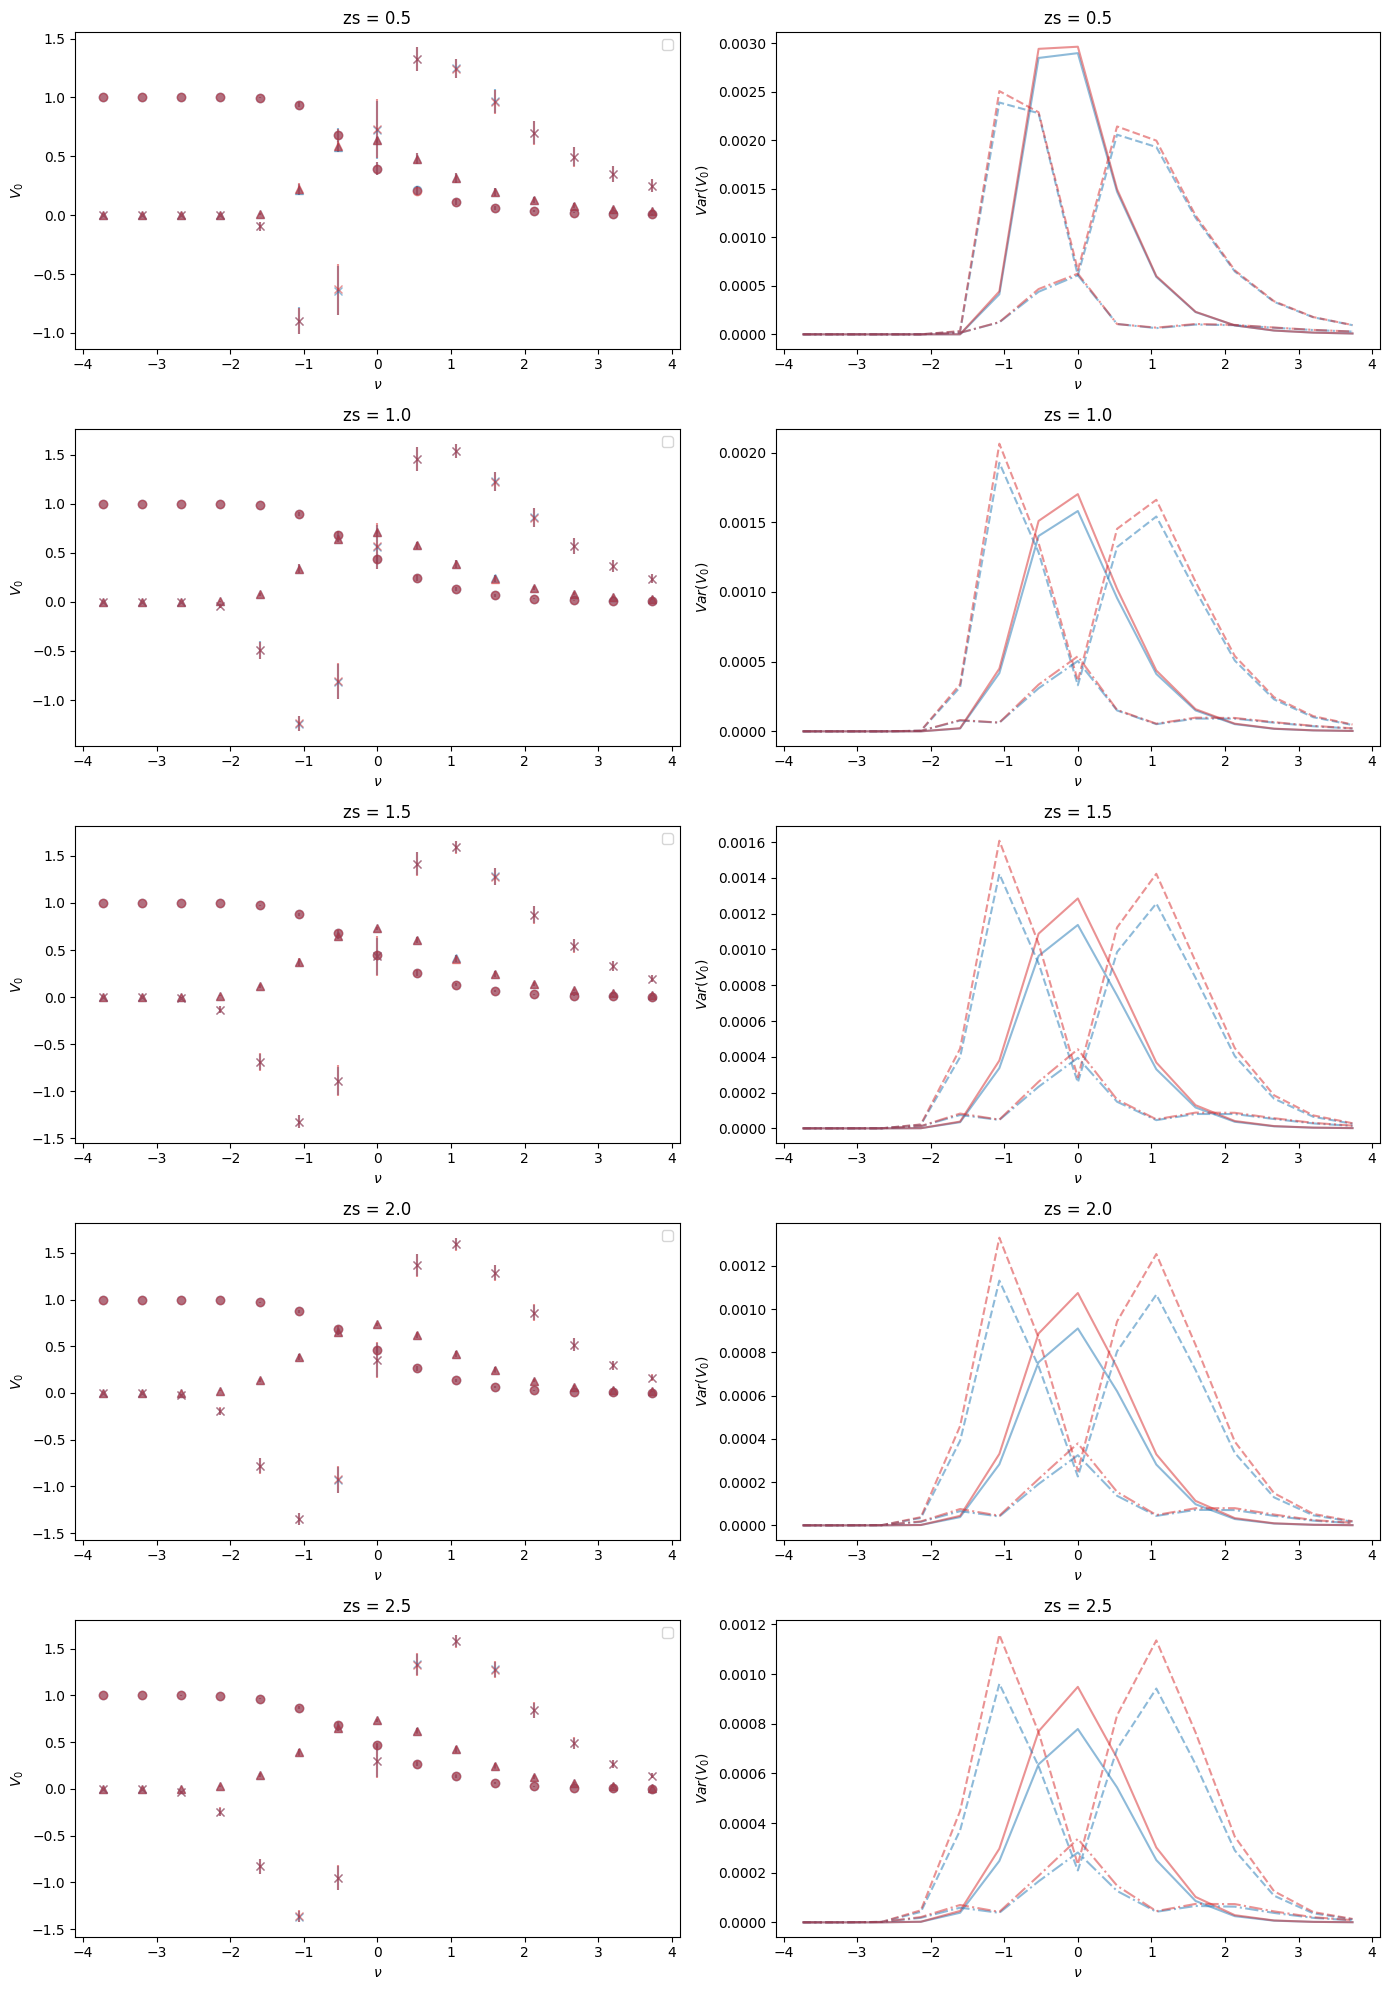

In [19]:
m0 = Gaussian_MF2(0, nu)


fig, ax = plt.subplots(5, 2, figsize=(14, 20))
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    ax[i, 0].errorbar(nu, clkk_tiled[zs][0]["means"], yerr=clkk_tiled[zs][0]["stds"], fmt="o", color="tab:blue", alpha=0.5)
    ax[i, 0].errorbar(nu, clkk_bigbox[zs][0]["means"], yerr=clkk_bigbox[zs][0]["stds"], fmt="o", color="tab:red", alpha=0.5)

    ax[i, 0].errorbar(nu, clkk_tiled[zs][1]["means"]*100, yerr=clkk_tiled[zs][1]["stds"]*100, fmt="^", color="tab:blue", alpha=0.5)
    ax[i, 0].errorbar(nu, clkk_bigbox[zs][1]["means"]*100, yerr=clkk_bigbox[zs][1]["stds"]*100, fmt="^", color="tab:red", alpha=0.5)

    ax[i, 0].errorbar(nu, clkk_tiled[zs][2]["means"]*10000, yerr=clkk_tiled[zs][2]["stds"]*10000, fmt="x", color="tab:blue", alpha=0.5)
    ax[i, 0].errorbar(nu, clkk_bigbox[zs][2]["means"]*10000, yerr=clkk_bigbox[zs][2]["stds"]*10000, fmt="x", color="tab:red", alpha=0.5)
    
    ax[i, 0].set_title(f"zs = {zs}")
    ax[i, 0].set_xlabel(r"$\nu$")
    ax[i, 0].set_ylabel(r"$V_0$")
    ax[i, 0].legend()

    ax[i, 1].plot(nu, clkk_tiled[zs][0]["diags"], color="tab:blue", alpha = 0.5)
    ax[i, 1].plot(nu, clkk_bigbox[zs][0]["diags"], color="tab:red", alpha = 0.5)

    ax[i, 1].plot(nu, clkk_tiled[zs][1]["diags"]*10000, color="tab:blue", alpha = 0.5, linestyle="--")
    ax[i, 1].plot(nu, clkk_bigbox[zs][1]["diags"]*10000, color="tab:red", alpha = 0.5, linestyle="--")

    ax[i, 1].plot(nu, clkk_tiled[zs][2]["diags"]*1000000, color="tab:blue", alpha = 0.5, linestyle="-.")
    ax[i, 1].plot(nu, clkk_bigbox[zs][2]["diags"]*1000000, color="tab:red", alpha = 0.5, linestyle="-.")


    ax[i, 1].set_title(f"zs = {zs}")
    ax[i, 1].set_xlabel(r"$\nu$")
    ax[i, 1].set_ylabel(r"$Var(V_0)$")

plt.tight_layout()
plt.show()